# `1 Find Sudoku Square`

notas:
    img 2
    hay celdas con varios puntos blancos como se puede eliminar ?
    graficar los contornos encontrados de color verde; ojo que la imagen esta en griss
    se peude graficar el bpoundingbox? ayudara a escalar? lo que hay dentro?? como funciona boundingbox?
    como engrogar los bordes?
    
    ojo imagen 25 que paso


    

Text(0.5, 1.0, 'Sudoku')

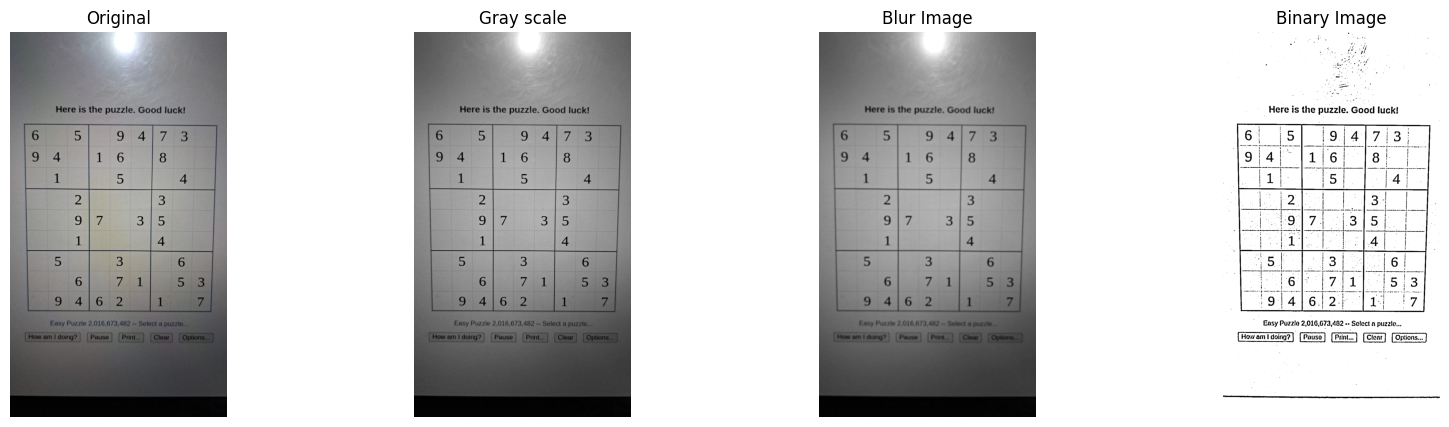

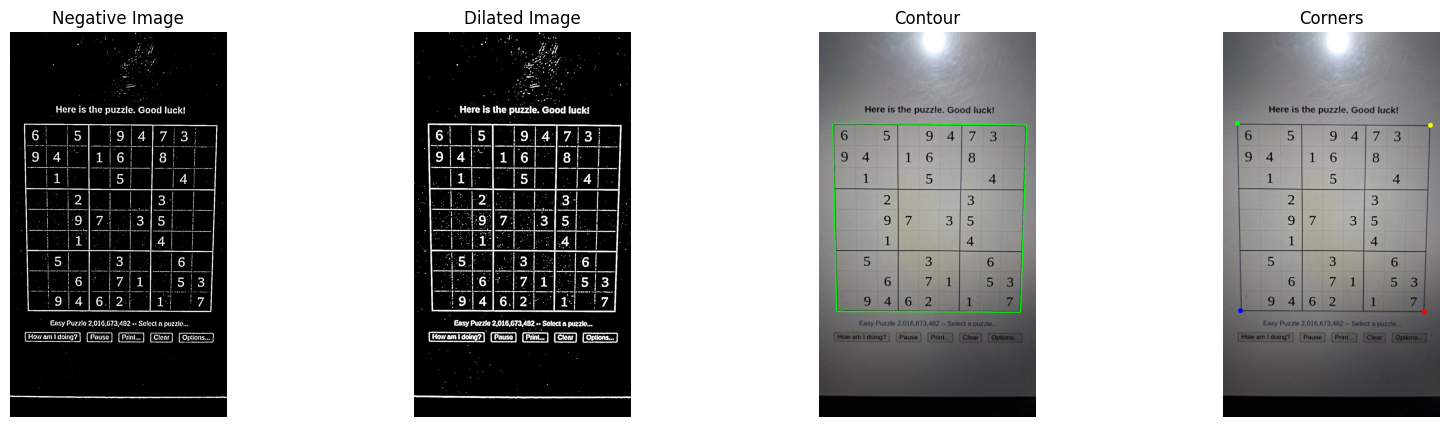

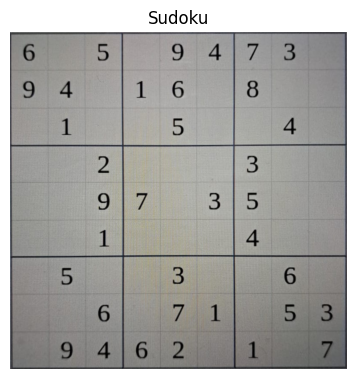

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import operator

img = cv2.imread(f"../data/example.jpeg")

# convert to gray scale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply gaussian blur
blur_img = cv2.GaussianBlur(gray_img, (9, 9), 0)

# binarize image
binary_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# invert image
negative_img = cv2.bitwise_not(binary_img)

# apply dilation
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
dilated_img = cv2.dilate(negative_img, kernel, iterations=1)

# find contours
contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
img_with_contour = img.copy()
cv2.drawContours(img_with_contour, [max_contour], -1, (0, 255, 0), 3)

# find corners
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in max_contour]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in max_contour]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in max_contour]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in max_contour]), key=operator.itemgetter(1))

# extract corner points
bottom_right = max_contour[bottom_right][0]
top_left = max_contour[top_left][0]
bottom_left = max_contour[bottom_left][0]
top_right = max_contour[top_right][0]
img_with_points = img.copy()
cv2.circle(img_with_points, tuple(bottom_right), 10, (0, 0, 255), -1)
cv2.circle(img_with_points, tuple(top_left), 10, (0, 255, 0), -1)
cv2.circle(img_with_points, tuple(bottom_left), 10, (255, 0, 0), -1)
cv2.circle(img_with_points, tuple(top_right), 10, (0, 255, 255), -1)

# get perspective
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
side = max([
    distance_between(bottom_right, top_right),
    distance_between(top_left, bottom_left),
    distance_between(bottom_right, bottom_left),
    distance_between(top_left, top_right)
])

dst = np.array([
    [0, 0],
    [side - 1, 0],
    [side - 1, side - 1],
    [0, side - 1]
], dtype='float32')

m = cv2.getPerspectiveTransform(src, dst)
warped_img = cv2.warpPerspective(img, m, (int(side), int(side)))

# show images
plt.figure(figsize=(20, 5))
plt.subplot(141); plt.axis("off"); plt.imshow(img[:,:,::-1]); plt.title("Original")
plt.subplot(142); plt.axis("off"); plt.imshow(gray_img, cmap="gray"); plt.title("Gray scale")
plt.subplot(143); plt.axis("off"); plt.imshow(blur_img, cmap="gray"); plt.title("Blur Image")
plt.subplot(144); plt.axis("off"); plt.imshow(binary_img, cmap="gray"); plt.title("Binary Image")
plt.figure(figsize=(20, 5))
plt.subplot(141); plt.axis("off"); plt.imshow(negative_img, cmap="gray"); plt.title("Negative Image")
plt.subplot(142); plt.axis("off"); plt.imshow(dilated_img, cmap="gray"); plt.title("Dilated Image")
plt.subplot(143); plt.axis("off"); plt.imshow(img_with_contour[:,:,::-1]); plt.title("Contour")
plt.subplot(144); plt.axis("off"); plt.imshow(img_with_points[:,:,::-1]); plt.title("Corners")
plt.figure(figsize=(20, 5))
plt.subplot(141); plt.axis("off"); plt.imshow(warped_img[:,:,::-1]); plt.title("Sudoku")

# `2 Draw lines`

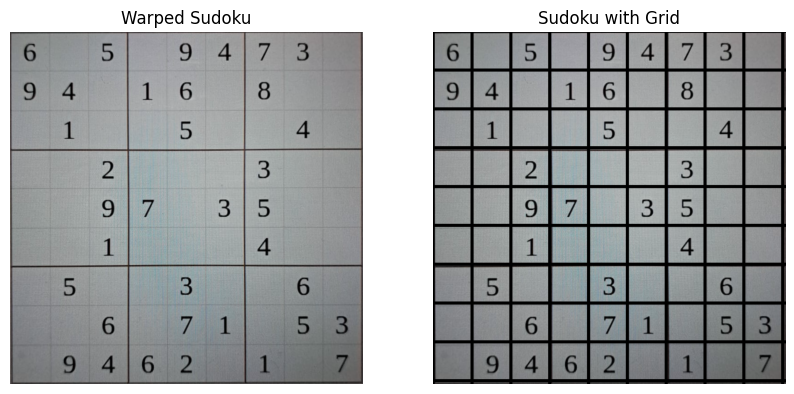

In [3]:
# Get dimensions of the image
height, width = warped_img.shape[:2]  # Ensure obtaining height and width in grayscale

# Calculate the size of each cell
cell_height = height // 9  # Assume a 9x9 grid for Sudoku
cell_width = width // 9

# Create a copy of the image to draw the grid
grid_image = warped_img.copy()

# Draw horizontal lines, including the lines at the top and bottom edges
for i in range(10):  # Adjusted to 10 to include top and bottom edges
    y = min(i * cell_height, height - 1)  # Ensure the bottom edge is within bounds
    cv2.line(grid_image, (0, y), (width - 1, y), (0, 0, 0), 5)  # Black line with thickness 5

# Draw vertical lines, including the lines at the left and right edges
for i in range(10):  # Adjusted to 10 to include left and right edges
    x = min(i * cell_width, width - 1)  # Ensure the right edge is within bounds
    cv2.line(grid_image, (x, 0), (x, height - 1), (0, 0, 0), 5)  # Black line with thickness 5

# Display the result with the reinforced grid
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.axis("off"); plt.imshow(warped_img, cmap='gray'); plt.title("Warped Sudoku")
plt.subplot(122); plt.axis("off"); plt.imshow(grid_image, cmap='gray'); plt.title("Sudoku with Grid");

# `3 Divide Sudoku on Cells`

In [109]:
import os
from datetime import datetime

# Directory to save cells containing digits
save_dir = "../data/cells"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create a CLAHE object for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4, 4))

# Convert grid_image to grayscale if it is not already
gray_grid_image = cv2.cvtColor(grid_image, cv2.COLOR_BGR2GRAY)

# Margin to define the internal region of interest (ROI)
margin = 20  # Adjustment for the region of interest

# Iterate over the 9x9 grid to extract and process each cell
for i in range(9):
    for j in range(9):
        # Define cell boundaries
        x_start = j * cell_width
        y_start = i * cell_height
        x_end = x_start + cell_width
        y_end = y_start + cell_height
        
        # Crop the cell from the grayscale image
        cell = gray_grid_image[y_start:y_end, x_start:x_end]
        cell = clahe.apply(cell)  # Apply CLAHE

        # Normalize the cell
        cell = cv2.normalize(cell, None, 0, 255, cv2.NORM_MINMAX)

        # Binarize the cell and invert colors
        _, binary_cell = cv2.threshold(cell, 90, 255, cv2.THRESH_BINARY_INV)

        # Define the region of interest (ROI)
        roi = binary_cell[margin:cell_height-margin, margin:cell_width-margin]

        # Detect contours within the internal region
        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter and process cells with content (digits)
        if len(contours) > 0 and max(cv2.contourArea(contour) for contour in contours) >= 20:
            # Process cell containing a digit
            for contour in contours:
                if cv2.contourArea(contour) > 20:
                    x, y, w, h = cv2.boundingRect(contour)
                    digit_region = binary_cell[y + margin:y + h + margin, x + margin:x + w + margin]

                    # Resize the digit while keeping the aspect ratio
                    aspect_ratio = w / h
                    if w > h:
                        new_w = 28
                        new_h = int(new_w / aspect_ratio)
                    else:
                        new_h = 28
                        new_w = int(new_h * aspect_ratio)

                    # Scale the digit
                    scaled_digit = cv2.resize(digit_region, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

                    # Center the digit in a 28x28 image
                    final_cell = np.zeros((28, 28), dtype=np.uint8)
                    x_offset = (28 - new_w) // 2
                    y_offset = (28 - new_h) // 2
                    final_cell[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = scaled_digit

                    # Save only the cell with the digit, using a timestamped filename for uniqueness
                    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")  # Timestamp with milliseconds
                    cv2.imwrite(os.path.join(save_dir, f"{timestamp}.png"), final_cell)
